# Preprocessing

Ce notebook comprendra le nettoyage et le feature engeneering sur la base des conclusions de l'EDA 
    

In [1]:
# chargement librairies
import numpy as np
import pandas as pd 
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline 
import datetime
import sys
import time
from datetime import datetime
# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_all_tables(directory_path='', verbose=True):
    '''
    Function to load all the tables required
    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not
    '''
    if verbose:
        print("Chargement des jeux de donnees...")
        print("--------------------------------------------------------------------")
        start = datetime.now()

    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Fichier application_train.csv chargé -> dataframe : application_train")

    application_test = pd.read_csv(directory_path + 'application_test.csv')
    if verbose:
        print("Fichier application_test.csv chargé -> dataframe : application_test")

    bureau = pd.read_csv(directory_path + 'bureau.csv')
    if verbose:
        print("Fichier bureau.csv chargé -> dataframe : bureau")

    bureau_balance = pd.read_csv(directory_path + 'bureau_balance.csv')
    if verbose:
        print("Fichier bureau_balance.csv chargé -> dataframe : bureau_balance")

    cc_balance = pd.read_csv(directory_path + 'credit_card_balance.csv')
    if verbose:
        print("Fichier credit_card_balance.csv chargé -> dataframe : cc_balance")

    installments_payments = pd.read_csv(
        directory_path + 'installments_payments.csv')
    if verbose:
        print(
            "Fichier installments_payments.csv chargé -> dataframe : installments_payments")

    POS_CASH_balance = pd.read_csv(directory_path + 'POS_CASH_balance.csv')
    if verbose:
        print("Fichier POS_CASH_balance.csv chargé -> dataframe : POS_CASH_balance")

    HomeCredit_columns_description = pd.read_csv(
        directory_path +
        'HomeCredit_columns_description.csv',
        encoding='cp1252')
    del HomeCredit_columns_description['Unnamed: 0']
    if verbose:
        print("Fichier HomeCredit_columns_description.csv chargé -> dataframe : HomeCredit_columns_description")

    previous_application = pd.read_csv(
        directory_path + 'previous_application.csv')
    if verbose:
        print("Fichier previous_application.csv chargé -> dataframe : previous_application")

    if verbose:
        print("--------------------------------------------------------------------")
        print(
            f'Chargement des 9 jeux de donnees termineéen {datetime.now() - start} secondes')

    return application_train, application_test, bureau, bureau_balance, \
        cc_balance, installments_payments, POS_CASH_balance, previous_application, \
        HomeCredit_columns_description

In [3]:
path=r'C:/Users/mehan/Desktop/DATA SCIENTIST/P07/data_csv/'
application_train, application_test, bureau, bureau_balance, cc_balance, \
    installments_payments, POS_CASH_balance, previous_application, \
    HomeCredit_columns_description =load_all_tables(path)

Chargement des jeux de donnees...
--------------------------------------------------------------------
Fichier application_train.csv chargé -> dataframe : application_train
Fichier application_test.csv chargé -> dataframe : application_test
Fichier bureau.csv chargé -> dataframe : bureau
Fichier bureau_balance.csv chargé -> dataframe : bureau_balance
Fichier credit_card_balance.csv chargé -> dataframe : cc_balance
Fichier installments_payments.csv chargé -> dataframe : installments_payments
Fichier POS_CASH_balance.csv chargé -> dataframe : POS_CASH_balance
Fichier HomeCredit_columns_description.csv chargé -> dataframe : HomeCredit_columns_description
Fichier previous_application.csv chargé -> dataframe : previous_application
--------------------------------------------------------------------
Chargement des 9 jeux de donnees termineéen 0:00:50.907630 secondes


### traintement fichier principal : application_train

In [4]:
application_train.shape

(307511, 122)

In [5]:
# variables quanti
cols_num=application_train.select_dtypes(include=[np.number]).columns.to_list()

In [6]:
# variables quali
cols_cat=application_train.select_dtypes(exclude=[np.number]).columns.to_list()

In [7]:
# reduction mémoire 
# # source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(data, verbose=True):
   
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''

    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-' * 79)
        print('Memory usage du dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
        col_type = data[col].dtype

        #  Float et int
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(
                        np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if c_min > np.finfo(
                        np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

        # # Boolean : pas à faire car pour machine learning il faut des int 0/1
        # et pas False/True
        # if list(data[col].unique()) == [0, 1] or list(data[col].unique()) == [1, 0]:
        #     data[col] = data[col].astype(bool)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage après optimization: {:.2f} MB'.format(end_mem))
        print('Diminution de {:.1f}%'.format(
            100 * (start_mem - end_mem) / start_mem))
        print('-' * 79)

    return data

In [8]:
reduce_mem_usage(application_train, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 286.23 MB
Memory usage après optimization: 92.38 MB
Diminution de 67.7%
-------------------------------------------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
cols_num

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

In [10]:
# transformer les variables dans la bonne catégorie
application_train['REGION_RATING_CLIENT'].unique()


array([2, 1, 3], dtype=int8)

In [11]:
application_train['REGION_RATING_CLIENT']=application_train['REGION_RATING_CLIENT'].astype('object')

In [12]:
application_train['REGION_RATING_CLIENT_W_CITY'].unique()

array([2, 1, 3], dtype=int8)

In [13]:
application_train['REGION_RATING_CLIENT_W_CITY']=application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')

In [14]:
cols_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [15]:
#correction Gender
application_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [16]:
application_train[application_train['CODE_GENDER'] =='XNA']['CODE_GENDER'].count()

4

In [17]:
# Correction : difficile d'imputer le sexe par le mode de cette catégorie
# Comme il n'y a que 4 clients avec un sexe non renseigné, on supprime ces
# valeurs
application_train =  application_train[application_train['CODE_GENDER'] != 'XNA']

In [18]:
# correction Name family statut
application_train['NAME_FAMILY_STATUS'].unique()

array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)

In [19]:
# Nombre de lignes ayant la valeur 'Maternity leave' ?
application_train[application_train['NAME_FAMILY_STATUS'] ==
                  'Unknown']['NAME_FAMILY_STATUS'].count()

2

In [20]:
# Correction : remplacer 'Unknown' par np.nan
application_train['NAME_FAMILY_STATUS'] = \
    [row if row != 'Unknown' else np.nan for row in
     application_train['NAME_FAMILY_STATUS']]


## 2-Merge des fichiers, nettoyage et feature engeneering 

In [21]:
print('The shape of data before:',application_train.shape)


The shape of data before: (307507, 122)


In [22]:
# Creation of test and train dataframe
train_set=application_train
test_set = application_test


In [23]:
#Create a simple dataset with the train / test merge app
train_set = test_set.append(train_set)

In [24]:
print('Train:' + str(train_set.shape))
print('Test:' + str(test_set.shape))

Train:(356251, 122)
Test:(48744, 121)


In [25]:
#Now just in case, let's check if we've got it right
# Les deux jeux de données ont exactement le même format avec une seule différence, la TARGET dispo dans le train.
train_set.TARGET.isna().sum()

48744

In [26]:
sum(train_set.SK_ID_CURR[train_set.TARGET.isna()] == application_test.SK_ID_CURR) 

48744

In [27]:
#Total number of previous credits taken by each customer
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns ={'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [28]:
train_set = train_set.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values with 0 
train_set['PREVIOUS_LOANS_COUNT'] = train_set['PREVIOUS_LOANS_COUNT'].fillna(0)
print("The shape of train_set after merging:")
display(train_set.shape)
print("=="*50)
display(train_set.head())

The shape of train_set after merging:


(356251, 123)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,PREVIOUS_LOANS_COUNT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,NaN,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0.0,0.0,0.0,0.0,1.0,4.0,NaN,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,NaN,12.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [29]:
test_set = test_set.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values with 0 
test_set['PREVIOUS_LOANS_COUNT'] = test_set['PREVIOUS_LOANS_COUNT'].fillna(0)
print("The shape of test_set after merging:")
display(test_set.shape)
print("=="*50)
display(test_set.head())

The shape of test_set after merging:


(48744, 122)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREVIOUS_LOANS_COUNT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,12.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [30]:
#Monthly average balances of previous credits in Credit Bureau.
bureau_bal_mean = bureau_balance.groupby('SK_ID_BUREAU', as_index=False).mean().rename(columns = 
                                        {'MONTHS_BALANCE': 'MONTHS_BALANCE_MEAN'})
bureau_bal_mean.head()

,SK_ID_BUREAU,MONTHS_BALANCE_MEAN
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


In [31]:
bureau_full = bureau.merge(bureau_bal_mean, on='SK_ID_BUREAU', how='left')
bureau_full.drop('SK_ID_BUREAU', axis=1, inplace=True)
display(bureau_full.head())
display(bureau_full.shape)

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MEAN
0,215354,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN


(1716428, 17)

In [32]:
bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_')
bureau_mean = bureau_mean.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
bureau_mean.shape

(305811, 14)

In [33]:
train_set = train_set.merge(bureau_mean, on='SK_ID_CURR', how='left')
# Fill the missing values with 0 
train_set['PREVIOUS_LOANS_COUNT'] = train_set['PREVIOUS_LOANS_COUNT'].fillna(0)
print("The shape of train_set after merging:")
display(train_set.shape)
print("=="*50)
display(train_set.head())

The shape of train_set after merging:


(356251, 136)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,-825.500000,NaN,0.0,207623.571429,85240.928571,0.000000,0.0,-93.142857,3545.357143,-11.785714
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,-123.000000,0.0,0.0,219042.000000,189469.500000,0.000000,0.0,-54.333333,1420.500000,-3.000000
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,-1054.750000,19305.0,0.0,518070.015000,0.000000,NaN,0.0,-775.500000,0.000000,-28.250000
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,-1238.285714,0.0,0.0,126739.590000,18630.450000,14484.394286,0.0,-651.500000,3012.010714,-22.833333
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
test_set = test_set.merge(bureau_mean, on='SK_ID_CURR', how='left')
# Fill the missing values with 0 
test_set['PREVIOUS_LOANS_COUNT'] = test_set['PREVIOUS_LOANS_COUNT'].fillna(0)
print("The shape of test_set after merging:")
display(test_set.shape)
print("=="*50)
display(test_set.head())

The shape of test_set after merging:


(48744, 135)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,-825.500000,NaN,0.0,207623.571429,85240.928571,0.000000,0.0,-93.142857,3545.357143,-11.785714
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,-123.000000,0.0,0.0,219042.000000,189469.500000,0.000000,0.0,-54.333333,1420.500000,-3.000000
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,-1054.750000,19305.0,0.0,518070.015000,0.000000,NaN,0.0,-775.500000,0.000000,-28.250000
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,-1238.285714,0.0,0.0,126739.590000,18630.450000,14484.394286,0.0,-651.500000,3012.010714,-22.833333
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#Number of previous applications of the clients to Home Credit
previous_application_counts = previous_application.groupby('SK_ID_CURR', 
                                                           as_index=False)['SK_ID_PREV'].count().rename(
                                                           columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()

,SK_ID_CURR,PREVIOUS_APPLICATION_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [36]:
train_set = train_set.merge(previous_application_counts, on='SK_ID_CURR', how='left')
# Fill the missing values with 0 
train_set['PREVIOUS_LOANS_COUNT'] = train_set['PREVIOUS_LOANS_COUNT'].fillna(0)
print("The shape of train_set after merging:")
display(train_set.shape)
print("=="*50)
display(train_set.head())

The shape of train_set after merging:


(356251, 137)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,NaN,0.0,207623.571429,85240.928571,0.000000,0.0,-93.142857,3545.357143,-11.785714,1.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,219042.000000,189469.500000,0.000000,0.0,-54.333333,1420.500000,-3.000000,2.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,19305.0,0.0,518070.015000,0.000000,NaN,0.0,-775.500000,0.000000,-28.250000,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,126739.590000,18630.450000,14484.394286,0.0,-651.500000,3012.010714,-22.833333,5.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [37]:
test_set = test_set.merge(previous_application_counts, on='SK_ID_CURR', how='left')
# Fill the missing values with 0 
test_set['PREVIOUS_LOANS_COUNT'] = test_set['PREVIOUS_LOANS_COUNT'].fillna(0)
print("The shape of test_set after merging:")
display(test_set.shape)
print("=="*50)
display(test_set.head())

The shape of test_set after merging:


(48744, 136)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,NaN,0.0,207623.571429,85240.928571,0.000000,0.0,-93.142857,3545.357143,-11.785714,1.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,219042.000000,189469.500000,0.000000,0.0,-54.333333,1420.500000,-3.000000,2.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,19305.0,0.0,518070.015000,0.000000,NaN,0.0,-775.500000,0.000000,-28.250000,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,126739.590000,18630.450000,14484.394286,0.0,-651.500000,3012.010714,-22.833333,5.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [38]:
# Remove SK_ID_CURR :
cc_balance.drop('SK_ID_CURR', axis=1, inplace=True)



In [39]:
cc_balance_mean = cc_balance.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
cc_balance_mean.rename(columns = {'CARD_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
cc_balance_mean.shape

(104307, 21)

In [40]:
#Merge with previous_application
previous_application = previous_application.merge(cc_balance_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 57)

In [41]:
installments_payments.drop('SK_ID_CURR', axis=1, inplace=True)
install_pay_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('INSTALL_MEAN_')
install_pay_mean.rename(columns = {'INSTALL_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
install_pay_mean.shape

(997752, 7)

In [42]:
#Merge with previous_application
previous_application = previous_application.merge(install_pay_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 63)

In [43]:
POS_CASH_balance.drop('SK_ID_CURR', axis=1, inplace=True)
POS_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('POS_MEAN_')
POS_mean.rename(columns = {'POS_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
POS_mean.shape

(997752, 7)

In [44]:
#Merge with previous_application
previous_application = previous_application.merge(POS_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 69)

In [45]:
prev_appl_mean = previous_application.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_APPL_MEAN_')
prev_appl_mean.rename(columns = {'PREV_APPL_MEAN_SK_ID_CURR' : 'SK_ID_CURR'}, inplace=True)
prev_appl_mean = prev_appl_mean.drop('PREV_APPL_MEAN_SK_ID_PREV', axis=1)

In [46]:
train_set = train_set.merge(prev_appl_mean, on='SK_ID_CURR', how='left')
# Fill the missing values with 0 
train_set['PREVIOUS_LOANS_COUNT'] = train_set['PREVIOUS_LOANS_COUNT'].fillna(0)
print("The shape of train_set after merging:")
display(train_set.shape)
print("=="*50)
display(train_set.head())

The shape of train_set after merging:


(356251, 188)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_POS_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_POS_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_AMT_PAYMENT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,-1664.000000,-1679.500000,7312.725000,7312.725000,1.250000,2.500000,-1664.000000,-1679.500000,7312.725000,7312.725000
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,-586.000000,-609.555556,6240.205000,6240.205000,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,-854.833333,-867.592593,16349.077917,13702.794792,1.050926,6.027778,-854.833333,-867.592593,16349.077917,13702.794792
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,-944.964286,-949.814286,7836.897982,7557.738339,1.038889,17.595238,-944.964286,-949.814286,7836.897982,7557.738339
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,-622.000000,-634.250000,11100.337500,11100.337500,1.000000,6.500000,-622.000000,-634.250000,11100.337500,11100.337500


In [47]:
test_set = test_set.merge(prev_appl_mean, on='SK_ID_CURR', how='left')
# Fill the missing values with 0 
test_set['PREVIOUS_LOANS_COUNT'] = test_set['PREVIOUS_LOANS_COUNT'].fillna(0)
print("The shape of test_set after merging:")
display(test_set.shape)
print("=="*50)
display(test_set.head())

The shape of test_set after merging:


(48744, 187)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_POS_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_POS_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_AMT_PAYMENT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,-1664.000000,-1679.500000,7312.725000,7312.725000,1.250000,2.500000,-1664.000000,-1679.500000,7312.725000,7312.725000
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,-586.000000,-609.555556,6240.205000,6240.205000,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,-854.833333,-867.592593,16349.077917,13702.794792,1.050926,6.027778,-854.833333,-867.592593,16349.077917,13702.794792
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,-944.964286,-949.814286,7836.897982,7557.738339,1.038889,17.595238,-944.964286,-949.814286,7836.897982,7557.738339
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,-622.000000,-634.250000,11100.337500,11100.337500,1.000000,6.500000,-622.000000,-634.250000,11100.337500,11100.337500


In [48]:
# Comparaison variables catégorielles du train set et du test set

In [49]:
for var in cols_cat :
    var_train = application_train[var].unique()
    var_test = application_test[var].unique()
    diff = [val for val in var_train if val not in var_test]
    if len(diff) > 0 and diff != 'nan':
        print(f'Variable {var} - catégories différentes : {diff}')
      

Variable NAME_TYPE_SUITE - catégories différentes : [nan]
Variable NAME_INCOME_TYPE - catégories différentes : ['Maternity leave']
Variable NAME_FAMILY_STATUS - catégories différentes : [nan]
Variable OCCUPATION_TYPE - catégories différentes : [nan]
Variable FONDKAPREMONT_MODE - catégories différentes : [nan]
Variable HOUSETYPE_MODE - catégories différentes : [nan]
Variable WALLSMATERIAL_MODE - catégories différentes : [nan]
Variable EMERGENCYSTATE_MODE - catégories différentes : [nan]


In [50]:
# NAME_INCOME_TYPE
train_set[train_set['NAME_INCOME_TYPE'] ==
                  'Maternity leave']['NAME_INCOME_TYPE'].count()

5

In [51]:
# Correction : remplacer 'Maternity leave' par np.nan
train_set['NAME_INCOME_TYPE'] = \
    [row if row != 'Maternity leave' else np.nan for row in
    train_set['NAME_INCOME_TYPE']]
# Vérification
train_set[train_set['NAME_INCOME_TYPE'] ==
                  'Maternity leave']['NAME_INCOME_TYPE'].count()

0

#### Valeurs manquantes

In [52]:
def get_missing_values(df_work, pourcentage, affiche_heatmap, retour=False):
    """Indicateurs sur les variables manquantes
       @param in : df_work dataframe obligatoire
                   pourcentage : boolean si True affiche le nombre heatmap
                   affiche_heatmap : boolean si True affiche la heatmap
       @param out : none
    """

    # 1. Nombre de valeurs manquantes totales
    nb_nan_tot = df_work.isna().sum().sum()
    nb_donnees_tot = np.product(df_work.shape)
    pourc_nan_tot = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    print(
        f'Valeurs manquantes : {nb_nan_tot} NaN pour {nb_donnees_tot} données ({pourc_nan_tot} %)')

    if pourcentage:
        print("-------------------------------------------------------------")
        print("Nombre et pourcentage de valeurs manquantes par variable\n")
        # 2. Visualisation du nombre et du pourcentage de valeurs manquantes
        # par variable
        values = df_work.isnull().sum()
        percentage = 100 * values / len(df_work)
        table = pd.concat([values, percentage.round(2)], axis=1)
        table.columns = [
            'Nombres de valeurs manquantes',
            '% de valeurs manquantes']
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending=False)
                .style.background_gradient('seismic'))

    if affiche_heatmap:
        print("-------------------------------------------------------------")
        print("Heatmap de visualisation des valeurs manquantes")
        # 3. Heatmap de visualisation des valeurs manquantes
        plt.figure(figsize=(20, 10))
        sns.heatmap(df_work.isna(), cbar=False)
        plt.show()

    if retour:
        return table

In [53]:
# Valeurs manquantes du dataframe
df_nan_applitrain = get_missing_values(train_set,
                                                   True, False, True)

Valeurs manquantes : 18573496 NaN pour 66975188 données (27.73 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,350530,98.390000
PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,350530,98.390000
PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,294310,82.610000
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,294227,82.590000
PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,294227,82.590000
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,294227,82.590000
PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,294227,82.590000
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,294227,82.590000
PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,294227,82.590000
PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,263804,74.050000


In [54]:
# Liste des variables ayant plus de 70% de valeurs manquantes
cols_nan_a_suppr = \
    df_nan_applitrain[df_nan_applitrain['% de valeurs manquantes'] > 70] \
    .index.to_list()
print(f'Nombre de variables à supprimer : {len(cols_nan_a_suppr)}')
cols_nan_a_suppr

Nombre de variables à supprimer : 22


['PREV_APPL_MEAN_RATE_INTEREST_PRIMARY',
 'PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED',
 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE',
 'PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE',
 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT',
 'PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MAT

In [55]:
# Suppression des variables avec un seuil de nan > 70%
train_set.drop(columns=cols_nan_a_suppr, inplace=True)
# Variables catégorielles
cols_cat = train_set.select_dtypes(exclude=[np.number]).columns \
    .to_list()
# Variables quantitatives
cols_num = train_set.select_dtypes(include=[np.number]).columns \
    .to_list()
# Taille : nombre de lignes/colonnes
nRow, nVar = train_set.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 356251 lignes et 166 variables.


In [56]:
# meme traitement sur ke jeu de test
test_set.drop(columns=cols_nan_a_suppr, inplace=True)
# Variables catégorielles
cols_cat = test_set.select_dtypes(exclude=[np.number]).columns \
    .to_list()
# Variables quantitatives
cols_num = test_set.select_dtypes(include=[np.number]).columns \
    .to_list()
# Taille : nombre de lignes/colonnes
nRow, nVar = test_set.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 48744 lignes et 165 variables.


### imputation
variables quantitatives imputées par median.
variables qualitatives imputées par mode.

In [57]:
# Variables quantitatives - imputation par médiane
nb_nan_median =train_set[cols_num].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
train_set.fillna(train_set[cols_num].median(), inplace=True)
# Vérification
nb_nan_median = train_set[cols_num].isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 11451163
Nombre de nan après imputation par median : 0


In [58]:
# Variables quantitatives - imputation par médiane
nb_nan_median_test =test_set[cols_num].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_set.fillna(test_set[cols_num].median(), inplace=True)
# Vérification
nb_nan_median_test = test_set[cols_num].isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 0
Nombre de nan après imputation par median : 0


In [59]:
# Variables qualitatives - imputation par mode de la variable
nb_nan_cat = train_set[cols_cat].isna().sum().sum()
print(f'Nombre de nan avant imputation par mode : {nb_nan_cat}')
for var in cols_cat:
    mode = train_set[var].mode()[0]
    train_set[var].fillna(mode, inplace=True)
nb_nan_cat =train_set[cols_cat].isna().sum().sum()
print(f'Nombre de nan après imputation par mode : {nb_nan_cat}')

Nombre de nan avant imputation par mode : 883405
Nombre de nan après imputation par mode : 0


In [60]:
# Variables qualitatives - imputation par mode de la variable
nb_nan_cat_test = test_set[cols_cat].isna().sum().sum()
print(f'Nombre de nan avant imputation par mode : {nb_nan_cat}')
for var in cols_cat:
    mode = test_set[var].mode()[0]
    test_set[var].fillna(mode, inplace=True)
nb_nan_cat_test =test_set[cols_cat].isna().sum().sum()
print(f'Nombre de nan après imputation par mode : {nb_nan_cat}')

Nombre de nan avant imputation par mode : 0
Nombre de nan après imputation par mode : 0


In [61]:
get_missing_values(train_set,True,False,True)

Valeurs manquantes : 48744 NaN pour 59137666 données (0.08 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
TARGET,48744,13.680000


,Nombres de valeurs manquantes,% de valeurs manquantes
SK_ID_CURR,0,0.0
NAME_CONTRACT_TYPE,0,0.0
CODE_GENDER,0,0.0
FLAG_OWN_CAR,0,0.0
FLAG_OWN_REALTY,0,0.0
...,...,...
PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_NUMBER,0,0.0
PREV_APPL_MEAN_POS_MEAN_DAYS_INSTALMENT,0,0.0
PREV_APPL_MEAN_POS_MEAN_DAYS_ENTRY_PAYMENT,0,0.0
PREV_APPL_MEAN_POS_MEAN_AMT_INSTALMENT,0,0.0


In [62]:
get_missing_values(test_set,True,False,True)

Valeurs manquantes : 0 NaN pour 8042760 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes


,Nombres de valeurs manquantes,% de valeurs manquantes
SK_ID_CURR,0,0.0
NAME_CONTRACT_TYPE,0,0.0
CODE_GENDER,0,0.0
FLAG_OWN_CAR,0,0.0
FLAG_OWN_REALTY,0,0.0
...,...,...
PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_NUMBER,0,0.0
PREV_APPL_MEAN_POS_MEAN_DAYS_INSTALMENT,0,0.0
PREV_APPL_MEAN_POS_MEAN_DAYS_ENTRY_PAYMENT,0,0.0
PREV_APPL_MEAN_POS_MEAN_AMT_INSTALMENT,0,0.0


In [63]:
# Vérification : plus de nan
# Valeurs manquantes du dataframe train_set
print(f'Nombre nan train_set : {train_set.isna().sum().sum()}')
print(f'Nombre nan train_set : {test_set.isna().sum().sum()}')

Nombre nan train_set : 48744
Nombre nan train_set : 0


#### FEATURES ENGINEERING

nous nous inspirons des variables crées sur le concours Kaggle pour les répliquer 
source : https://github.com/rishabhrao1997/Home-Credit-Default-Risk
   

In [64]:
 def feature_engineering_application(data):
    '''
    FEATURE ENGINEERING : création de nouvelles variables.
    Extrait de : https://github.com/rishabhrao1997/Home-Credit-Default-Risk
    Parameters
    ----------
    data : dataframe pour ajout de nouvelles variables, obligatoire.
    Returns
    -------
    None.
    '''
    
    # Ratio : Montant du crédit du prêt / Revenu du demandeur
    data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / \
        (data['AMT_INCOME_TOTAL'] + 0.00001)
    # Ratio : Montant du crédit du prêt / Annuité de prêt
    data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / \
        (data['AMT_ANNUITY'] + 0.00001)
    # Ratio : Annuité de prêt / Revenu du demandeur
    data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / \
        (data['AMT_INCOME_TOTAL'] + 0.00001)
    # Différence : Revenu du demandeur - Annuité de prêt
    data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - \
        data['AMT_ANNUITY']
    # Ratio : Montant du crédit du prêt / prix des biens pour lesquels le prêt est accordé
    # Crédit est supérieur au prix des biens ?
    data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / \
        (data['AMT_GOODS_PRICE'] + 0.00001)
    # Différence : Revenu du demandeur - prix des biens pour lesquels le prêt
    # est accordé
    data['INCOME_GOODS_DIFF'] = data['AMT_INCOME_TOTAL'] / \
        data['AMT_GOODS_PRICE']
    # Ratio : Annuité de prêt / Âge du demandeur au moment de la demande
    data['INCOME_AGE_RATIO'] = data['AMT_INCOME_TOTAL'] / (
        data['DAYS_BIRTH'] + 0.00001)
    # Ratio : Montant du crédit du prêt / Âge du demandeur au moment de la
    # demande
    data['CREDIT_AGE_RATIO'] = data['AMT_CREDIT'] / (
        data['DAYS_BIRTH'] + 0.00001)
    # Ratio : Revenu du demandeur / Score normalisé de la source de données
    # externe 3
    data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / \
        (data['EXT_SOURCE_3'] + 0.00001)
    # Ratio : Montant du crédit du prêt / Score normalisé de la source de
    # données externe
    data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / \
        (data['EXT_SOURCE_3'] + 0.00001)
    # Multiplication : Revenu du demandeur
    #                  * heure à laquelle le demandeur à fait sa demande de prêt
    data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * \
        data['HOUR_APPR_PROCESS_START']

    # -----------------------------------------------------------------------
    # Variables sur l'âge
    # -----------------------------------------------------------------------
    # YEARS_BIRTH - Âge du demandeur au moment de la demande DAYS_BIRTH en
    # années
    data['YEARS_BIRTH'] = data['DAYS_BIRTH'] * -1 / 365
    # Différence : Âge du demandeur - Ancienneté dans l'emploi à date demande
    data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    # Ratio : Ancienneté dans l'emploi à date demande / Âge du demandeur
    data['EMPLOYED_AGE_RATIO'] = data['DAYS_EMPLOYED'] / \
        (data['DAYS_BIRTH'] + 0.00001)
    # Ratio : nombre de jours avant la demande où le demandeur a changé de téléphone \
    #         äge du client
    data['LAST_PHONE_BIRTH_RATIO'] = data[
        'DAYS_LAST_PHONE_CHANGE'] / (data['DAYS_BIRTH'] + 0.00001)
    # Ratio : nombre de jours avant la demande où le demandeur a changé de téléphone \
    #         ancienneté dans l'emploi
    data['LAST_PHONE_EMPLOYED_RATIO'] = data[
        'DAYS_LAST_PHONE_CHANGE'] / (data['DAYS_EMPLOYED'] + 0.00001)

    # -----------------------------------------------------------------------
    # Variables sur la voiture
    # -----------------------------------------------------------------------
    # Différence : Âge de la voiture du demandeur -  Ancienneté dans l'emploi
    # à date demande
    data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
    # Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à date
    # demande
    data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / \
        (data['DAYS_EMPLOYED'] + 0.00001)
    # Différence : Âge du demandeur - Âge de la voiture du demandeur
    data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
    # Ratio : Âge de la voiture du demandeur / Âge du demandeur
    data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / \
        (data['DAYS_BIRTH'] + 0.00001)

    # -----------------------------------------------------------------------
    # Variables sur les contacts
    # -----------------------------------------------------------------------
    # Somme : téléphone portable? + téléphone professionnel? + téléphone
    #         professionnel fixe? + téléphone portable joignable? +
    #         adresse de messagerie électronique?
    data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + \
        data['FLAG_WORK_PHONE'] + data['FLAG_CONT_MOBILE'] + \
        data['FLAG_PHONE'] + data['FLAG_EMAIL']

    # -----------------------------------------------------------------------
    # Variables sur les membres de la famille
    # -----------------------------------------------------------------------
    # Différence : membres de la famille - enfants (adultes)
    data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
    # Ratio : nombre d'enfants / Revenu du demandeur
    data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / \
        (data['AMT_INCOME_TOTAL'] + 0.00001)
    # Ratio : Revenu du demandeur / membres de la famille : revenu par tête
    data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / \
        (data['CNT_FAM_MEMBERS'] + 1)

    # -----------------------------------------------------------------------
    # Variables sur la région
    # -----------------------------------------------------------------------
    # Moyenne : moyenne de notes de la région/ville où vit le client * revenu
    # du demandeur
    data['REGIONS_INCOME_MOY'] = (data['REGION_RATING_CLIENT'] +
                                  data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
    # Max : meilleure note de la région/ville où vit le client
    data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(
        data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
    # Min : plus faible note de la région/ville où vit le client
    data['REGION_RATING_MIN'] = [min(ele1, ele2) for ele1, ele2 in zip(
        data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
    # Moyenne : des notes de la région et de la ville où vit le client
    data['REGION_RATING_MEAN'] = (
        data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
    # Multipication : note de la région/ note de la ville où vit le client
    data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * \
        data['REGION_RATING_CLIENT_W_CITY']
    # Somme : des indicateurs  :
    # Indicateur si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent ou 0=identique - au niveau de la région)
    # Indicateur si l'adresse permanente du client ne correspond pas à l'adresse professionnelle (1=différent ou 0=identique - au niveau de la région)
    # Indicateur si l'adresse de contact du client ne correspond pas à l'adresse de travail (1=différent ou 0=identique - au niveau de la région).
    # Indicateur si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent ou 0=identique - au niveau de la ville)
    # Indicateur si l'adresse permanente du client ne correspond pas à l'adresse professionnelle (1=différent ou 0=même - au niveau de la ville).
    # Indicateur si l'adresse de contact du client ne correspond pas à
    # l'adresse de travail (1=différent ou 0=identique - au niveau de la
    # ville).
    data['FLAG_REGIONS_SUM'] = data['REG_REGION_NOT_LIVE_REGION'] + \
        data['REG_REGION_NOT_WORK_REGION'] + \
        data['LIVE_REGION_NOT_WORK_REGION'] + \
        data['REG_CITY_NOT_LIVE_CITY'] + \
        data['REG_CITY_NOT_WORK_CITY'] + \
        data['LIVE_CITY_NOT_WORK_CITY']

    # -----------------------------------------------------------------------
    # Variables sur les sources externes : sum, min, multiplication, max, var, scoring
    # -----------------------------------------------------------------------
    # Somme : somme des scores des 3 sources externes
    data['EXT_SOURCE_SUM'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                   'EXT_SOURCE_3']].sum(axis=1)
    # Moyenne : moyenne des scores des 3 sources externes
    data['EXT_SOURCE_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                    'EXT_SOURCE_3']].mean(axis=1)
    # Multiplication : des scores des 3 sources externes
    data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * \
        data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
    # Max : Max parmi les 3 scores des 3 sources externes
    data['EXT_SOURCE_MAX'] = [max(ele1, ele2, ele3) for ele1, ele2, ele3 in zip(
        data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
    # Min : Min parmi les 3 scores des 3 sources externes
    data['EXT_SOURCE_MIN'] = [min(ele1, ele2, ele3) for ele1, ele2, ele3 in zip(
        data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
    # Variance : variance des scores des 3 sources externes
    data['EXT_SOURCE_VAR'] = [np.var([ele1, ele2, ele3]) for ele1, ele2, ele3 in zip(
        data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
    # Scoring : scoring des scores des 3 sources externes, score 1 poids 2...
    data['WEIGHTED_EXT_SOURCE'] = data.EXT_SOURCE_1 * \
        2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4

    # -----------------------------------------------------------------------
    # Variables sur le bâtiment
    # -----------------------------------------------------------------------
    # Somme : Informations normalisées sur l'immeuble où vit le demandeur des moyennes
    # de la taille de l'appartement, de la surface commune, de la surface habitable,
    # de l'âge de l'immeuble, du nombre d'ascenseurs, du nombre d'entrées,
    # de l'état de l'immeuble et du nombre d'étages.
    data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
        'YEARS_BUILD_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
        'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data[
        'LIVINGAREA_AVG'] + data['NONLIVINGAREA_AVG']
    # Somme : Informations normalisées sur l'immeuble où vit le demandeur des modes
    # de la taille de l'appartement, de la surface commune, de la surface habitable,
    # de l'âge de l'immeuble, du nombre d'ascenseurs, du nombre d'entrées,
    # de l'état de l'immeuble et du nombre d'étages.
    data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
        'YEARS_BUILD_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
        'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data[
        'LIVINGAREA_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']
    # Somme : Informations normalisées sur l'immeuble où vit le demandeur des médianes
    # de la taille de l'appartement, de la surface commune, de la surface habitable,
    # de l'âge de l'immeuble, du nombre d'ascenseurs, du nombre d'entrées,
    # de l'état de l'immeuble et du nombre d'étages.
    data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
        'YEARS_BUILD_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
        'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + \
        data['NONLIVINGAREA_MEDI']
    # Multiplication : somme des moyennes des infos sur le bâtiment * revenu
    # du demandeur
    data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * \
        data['AMT_INCOME_TOTAL']
    # Multiplication : somme des modes des infos sur le bâtiment * revenu du
    # demandeur
    data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * \
        data['AMT_INCOME_TOTAL']
    # Multiplication : somme des médianes des infos sur le bâtiment * revenu
    # du demandeur
    data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * \
        data['AMT_INCOME_TOTAL']

    # -----------------------------------------------------------------------
    # Variables sur les défauts de paiements et les défauts observables
    # -----------------------------------------------------------------------
    # Somme : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 30 DPD (jours de retard) +
    #        nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 60 DPD (jours de retard)
    data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + \
        data['OBS_60_CNT_SOCIAL_CIRCLE']
    # Somme : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 30 DPD (jours de retard) +
    #        nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 60 DPD (jours de retard)
    data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + \
        data['DEF_60_CNT_SOCIAL_CIRCLE']
    # Multiplication : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 30 DPD (jours de retard) *
    #        nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 60 DPD (jours de retard)
    data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] * \
        data['DEF_30_CNT_SOCIAL_CIRCLE']
    # Multiplication : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 30 DPD (jours de retard) *
    #        nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 60 DPD (jours de retard)
    data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] * \
        data['DEF_60_CNT_SOCIAL_CIRCLE']
    # Somme : nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement ou des défauts observables avec 30
    #         DPD (jours de retard) et 60 DPD.
    data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + \
        data['OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
    # Ratio : Montant du crédit du prêt /
    #         nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 30 DPD (jours de retard)
    data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / \
        (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
    # Ratio : Montant du crédit du prêt /
    #         nombre d'observations de l'environnement social du demandeur
    #         avec des défauts observables de 60 DPD (jours de retard)
    data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / \
        (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
    # Ratio : Montant du crédit du prêt /
    #         nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 30 DPD (jours de retard)
    data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / \
        (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
    # Ratio : Montant du crédit du prêt /
    #         nombre d'observations de l'environnement social du demandeur
    #         avec des défauts de paiement de 60 DPD (jours de retard)
    data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / \
        (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)

    # -----------------------------------------------------------------------
    # Variables sur les indicateurs des documents fournis ou non
    # -----------------------------------------------------------------------
    # Toutes les variables DOCUMENT_
    cols_flag_doc = [flag for flag in data.columns if 'FLAG_DOC' in flag]
    # Somme : tous les indicateurs des documents fournis ou non
    data['FLAGS_DOCUMENTS_SUM'] = data[cols_flag_doc].sum(axis=1)
    # Moyenne : tous les indicateurs des documents fournis ou non
    data['FLAGS_DOCUMENTS_AVG'] = data[cols_flag_doc].mean(axis=1)
    # Variance : tous les indicateurs des documents fournis ou non
    data['FLAGS_DOCUMENTS_VAR'] = data[cols_flag_doc].var(axis=1)
    # Ecart-type : tous les indicateurs des documents fournis ou non
    data['FLAGS_DOCUMENTS_STD'] = data[cols_flag_doc].std(axis=1)

    # -----------------------------------------------------------------------
    # Variables sur le détail des modifications du demandeur : jour/heure...
    # -----------------------------------------------------------------------
    # Somme : nombre de jours avant la demande de changement de téléphone
    #         + nombre de jours avant la demande de changement enregistré sur la demande
    #         + nombre de jours avant la demande le client où il à
    #           changé la pièce d'identité avec laquelle il a demandé le prêt
    data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + \
        data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
    # Somme : nombre de demandes de renseignements sur le client adressées au Bureau de crédit
    # une heure + 1 jour + 1 mois + 3 mois + 1 an et 1 jour avant la demande
    data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + \
        data['AMT_REQ_CREDIT_BUREAU_MON'] + \
            data['AMT_REQ_CREDIT_BUREAU_QRT'] + \
                data['AMT_REQ_CREDIT_BUREAU_YEAR']
    # Ratio : somme du nombre de demandes de renseignements sur le client adressées au Bureau de crédit
    #         une heure + 1 jour + 1 mois + 3 mois + 1 an et 1 jour avant la demande \
    #         Montant du crédit du prêt
    data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / \
        (data['AMT_CREDIT'] + 0.00001)

    return data



In [65]:
train_set = feature_engineering_application(train_set)
train_set.shape

(356251, 225)

In [66]:
test_set = feature_engineering_application(test_set)
test_set.shape

(48744, 224)

####  ENCODAGE 
on va encoder les variables qualitatives afin de transformer les données en valeurs numériques, car les modèles que l'on va entraîner ne peuvent pas travailler sur des données qualitatives.


In [67]:
# Liste des variables catégorielles
cols_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [68]:
data_train = train_set[train_set['SK_ID_CURR'].isin(application_train.SK_ID_CURR)]
data_test = test_set[test_set['SK_ID_CURR'].isin(application_test.SK_ID_CURR)]

In [69]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (307507, 225)
Testing Features shape with categorical columns:  (48744, 224)


In [70]:
data_object_infos = data_train.select_dtypes("object").describe().T
data_object_infos["unique"] = data_train.select_dtypes("object").apply( pd.Series.unique, axis=0)
data_object_infos["nunique"] = data_train.select_dtypes("object").apply( pd.Series.nunique, axis=0)
data_object_infos

,count,unique,top,freq,nunique
NAME_CONTRACT_TYPE,307507,"[Cash loans, Revolving loans]",Cash loans,278232,2
CODE_GENDER,307507,"[M, F]",F,202448,2
FLAG_OWN_CAR,307507,"[N, Y]",N,202922,2
FLAG_OWN_REALTY,307507,"[Y, N]",Y,213308,2
NAME_TYPE_SUITE,307507,"[Unaccompanied, Family, Spouse, partner, Child...",Unaccompanied,249815,7
NAME_INCOME_TYPE,307507,"[Working, State servant, Commercial associate,...",Working,158776,7
NAME_EDUCATION_TYPE,307507,"[Secondary / secondary special, Higher educati...",Secondary / secondary special,218389,5
NAME_FAMILY_STATUS,307507,"[Single / not married, Married, Civil marriage...",Married,196431,5
NAME_HOUSING_TYPE,307507,"[House / apartment, Rented apartment, With par...",House / apartment,272865,6
OCCUPATION_TYPE,307507,"[Laborers, Core staff, Accountants, Managers, ...",Laborers,151575,18


In [71]:
test_data_object_infos = data_test.select_dtypes("object").describe().T
test_data_object_infos["unique"] = data_test.select_dtypes("object").apply( pd.Series.unique, axis=0)
test_data_object_infos["nunique"] = data_test.select_dtypes("object").apply( pd.Series.nunique, axis=0)
test_data_object_infos

,count,unique,top,freq,nunique
NAME_CONTRACT_TYPE,48744,"[Cash loans, Revolving loans]",Cash loans,48305,2
CODE_GENDER,48744,"[F, M]",F,32678,2
FLAG_OWN_CAR,48744,"[N, Y]",N,32311,2
FLAG_OWN_REALTY,48744,"[Y, N]",Y,33658,2
NAME_TYPE_SUITE,48744,"[Unaccompanied, Family, Spouse, partner, Group...",Unaccompanied,40638,7
NAME_INCOME_TYPE,48744,"[Working, State servant, Pensioner, Commercial...",Working,24533,7
NAME_EDUCATION_TYPE,48744,"[Higher education, Secondary / secondary speci...",Secondary / secondary special,33988,5
NAME_FAMILY_STATUS,48744,"[Married, Single / not married, Civil marriage...",Married,32283,5
NAME_HOUSING_TYPE,48744,"[House / apartment, With parents, Rented apart...",House / apartment,43645,6
OCCUPATION_TYPE,48744,"[Laborers, Low-skill Laborers, Drivers, Sales ...",Laborers,24260,18


In [72]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [73]:
data_train, cols_one_hot_encoded = one_hot_encoder(data_train, False)
print(f'{len(cols_one_hot_encoded)} colonnes on été "one hot encoded" :')
for col in cols_one_hot_encoded:
    print(f"- {col}")

137 colonnes on été "one hot encoded" :
- NAME_CONTRACT_TYPE_Cash loans
- NAME_CONTRACT_TYPE_Revolving loans
- CODE_GENDER_F
- CODE_GENDER_M
- FLAG_OWN_CAR_N
- FLAG_OWN_CAR_Y
- FLAG_OWN_REALTY_N
- FLAG_OWN_REALTY_Y
- NAME_TYPE_SUITE_Children
- NAME_TYPE_SUITE_Family
- NAME_TYPE_SUITE_Group of people
- NAME_TYPE_SUITE_Other_A
- NAME_TYPE_SUITE_Other_B
- NAME_TYPE_SUITE_Spouse, partner
- NAME_TYPE_SUITE_Unaccompanied
- NAME_INCOME_TYPE_Businessman
- NAME_INCOME_TYPE_Commercial associate
- NAME_INCOME_TYPE_Pensioner
- NAME_INCOME_TYPE_State servant
- NAME_INCOME_TYPE_Student
- NAME_INCOME_TYPE_Unemployed
- NAME_INCOME_TYPE_Working
- NAME_EDUCATION_TYPE_Academic degree
- NAME_EDUCATION_TYPE_Higher education
- NAME_EDUCATION_TYPE_Incomplete higher
- NAME_EDUCATION_TYPE_Lower secondary
- NAME_EDUCATION_TYPE_Secondary / secondary special
- NAME_FAMILY_STATUS_Civil marriage
- NAME_FAMILY_STATUS_Married
- NAME_FAMILY_STATUS_Separated
- NAME_FAMILY_STATUS_Single / not married
- NAME_FAMILY_STATU

In [74]:
data_test, cols_one_hot_encoded = one_hot_encoder(data_test, False)
print(f'{len(cols_one_hot_encoded)} colonnes on été "one hot encoded" :')
for col in cols_one_hot_encoded:
    print(f"- {col}")

137 colonnes on été "one hot encoded" :
- NAME_CONTRACT_TYPE_Cash loans
- NAME_CONTRACT_TYPE_Revolving loans
- CODE_GENDER_F
- CODE_GENDER_M
- FLAG_OWN_CAR_N
- FLAG_OWN_CAR_Y
- FLAG_OWN_REALTY_N
- FLAG_OWN_REALTY_Y
- NAME_TYPE_SUITE_Children
- NAME_TYPE_SUITE_Family
- NAME_TYPE_SUITE_Group of people
- NAME_TYPE_SUITE_Other_A
- NAME_TYPE_SUITE_Other_B
- NAME_TYPE_SUITE_Spouse, partner
- NAME_TYPE_SUITE_Unaccompanied
- NAME_INCOME_TYPE_Businessman
- NAME_INCOME_TYPE_Commercial associate
- NAME_INCOME_TYPE_Pensioner
- NAME_INCOME_TYPE_State servant
- NAME_INCOME_TYPE_Student
- NAME_INCOME_TYPE_Unemployed
- NAME_INCOME_TYPE_Working
- NAME_EDUCATION_TYPE_Academic degree
- NAME_EDUCATION_TYPE_Higher education
- NAME_EDUCATION_TYPE_Incomplete higher
- NAME_EDUCATION_TYPE_Lower secondary
- NAME_EDUCATION_TYPE_Secondary / secondary special
- NAME_FAMILY_STATUS_Civil marriage
- NAME_FAMILY_STATUS_Married
- NAME_FAMILY_STATUS_Separated
- NAME_FAMILY_STATUS_Single / not married
- NAME_FAMILY_STATU

In [75]:
print(data_train.shape)
print(data_test.shape)

(307507, 346)
(48744, 345)


In [76]:
# Préparation de la matrice de corrélation
# ---------------------------------------------------------------------
# Variables fortement corrélées : si le coef de Pearson est :
# > 0.8 ou < -0.8
# et inférieur à 1 ou > -1 (corrélée avec elle-même)
seuil = 0.8
# Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
# les corrélations positives et négatives séparément
corr = data_train.corr().abs()
# On ne conserve que la partie supérieur à la diagonale pour n'avoir
# qu'une seule fois les corrélations prisent en compte (symétrie axiale)
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

In [77]:
# Variables avec un coef de Pearson > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables fortement corrélées à supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

105 variables fortement corrélées à supprimer :

AMT_GOODS_PRICE
FLAG_EMP_PHONE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT_W_CITY
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
ELEVATORS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
PREV_APPL_MEAN_AMT_CREDIT
PREV_APPL_MEAN_AMT_GOODS_PRICE
PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION
PREV_APPL_MEAN_DAYS_TERMINATION
PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT
PREV_APPL_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT
PREV_

In [78]:
# Suppression des variables fortement corrélées
print(f'data_train : {data_train.shape}')
data_train.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'data_train : {data_train.shape}')

data_train : (307507, 346)
data_train : (307507, 241)


In [79]:
# Suppression des variables fortement corrélées
print(f'data_test : {data_test.shape}')
data_test.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'data_test : {data_test.shape}')

data_test : (48744, 345)
data_test : (48744, 240)


In [80]:
# Remplacer :, espaces... par '_' et mettre en majuscules le nom des variables
import re
data_train = data_train.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+',
                                                     '_', x.upper()))

In [81]:
data_test = data_test.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+',
                                                   '_', x.upper()))

In [85]:
# save data_train et data set pour utilisation ultérieure
data_train.to_csv('base_train.csv')


In [86]:
data_test.to_csv('base_test.csv')

In [82]:
#save our TARGET variable
target = data_train.TARGET 
data_train.drop('TARGET', axis=1, inplace=True) #remove TARGET from train

#Align the datasets
data_train, data_test = data_train.align(data_test, join='inner', axis=1)


In [83]:
print(target.shape)
print(data_train.shape)
print(data_test.shape)

(307507,)
(307507, 240)
(48744, 240)


<AxesSubplot:>

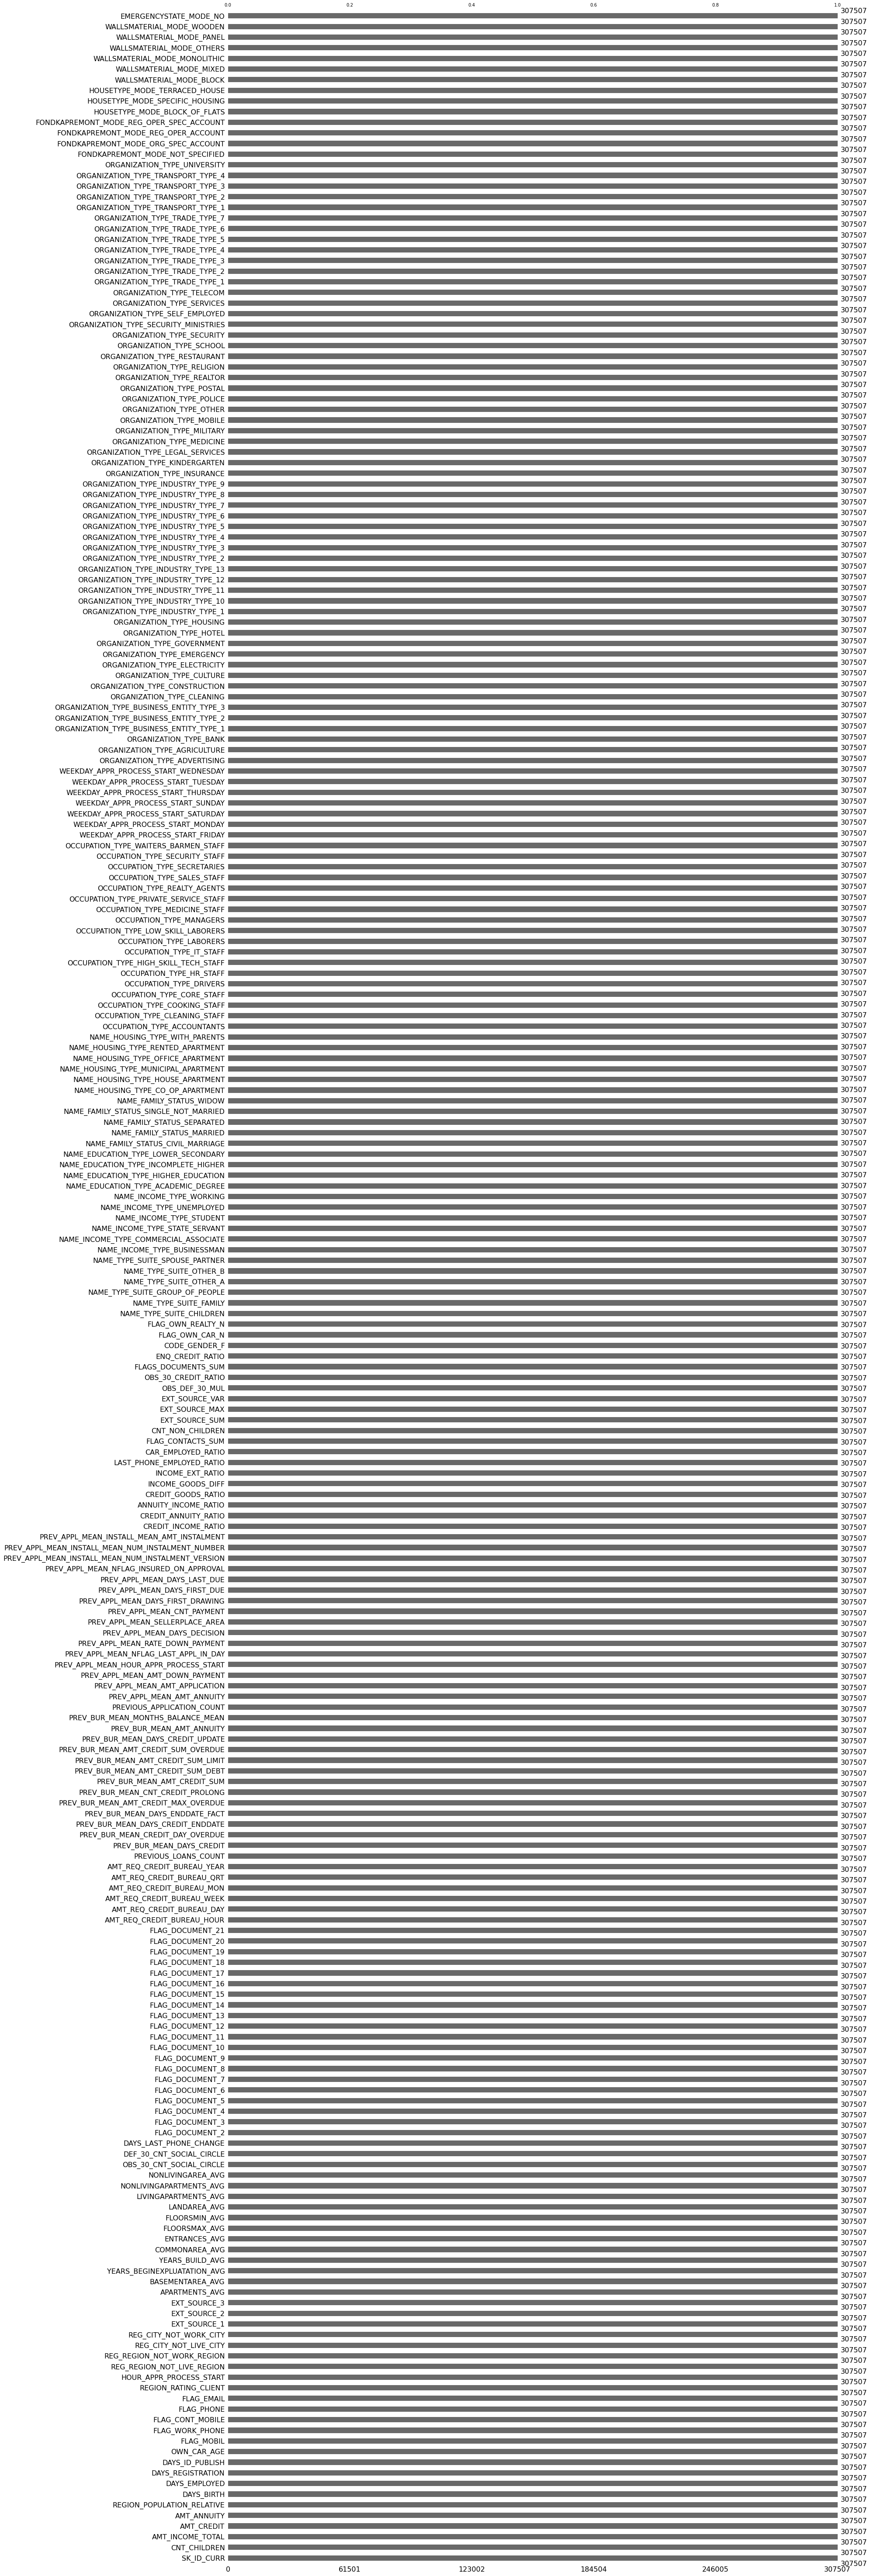

In [84]:
msno.bar(data_train)

<AxesSubplot:>

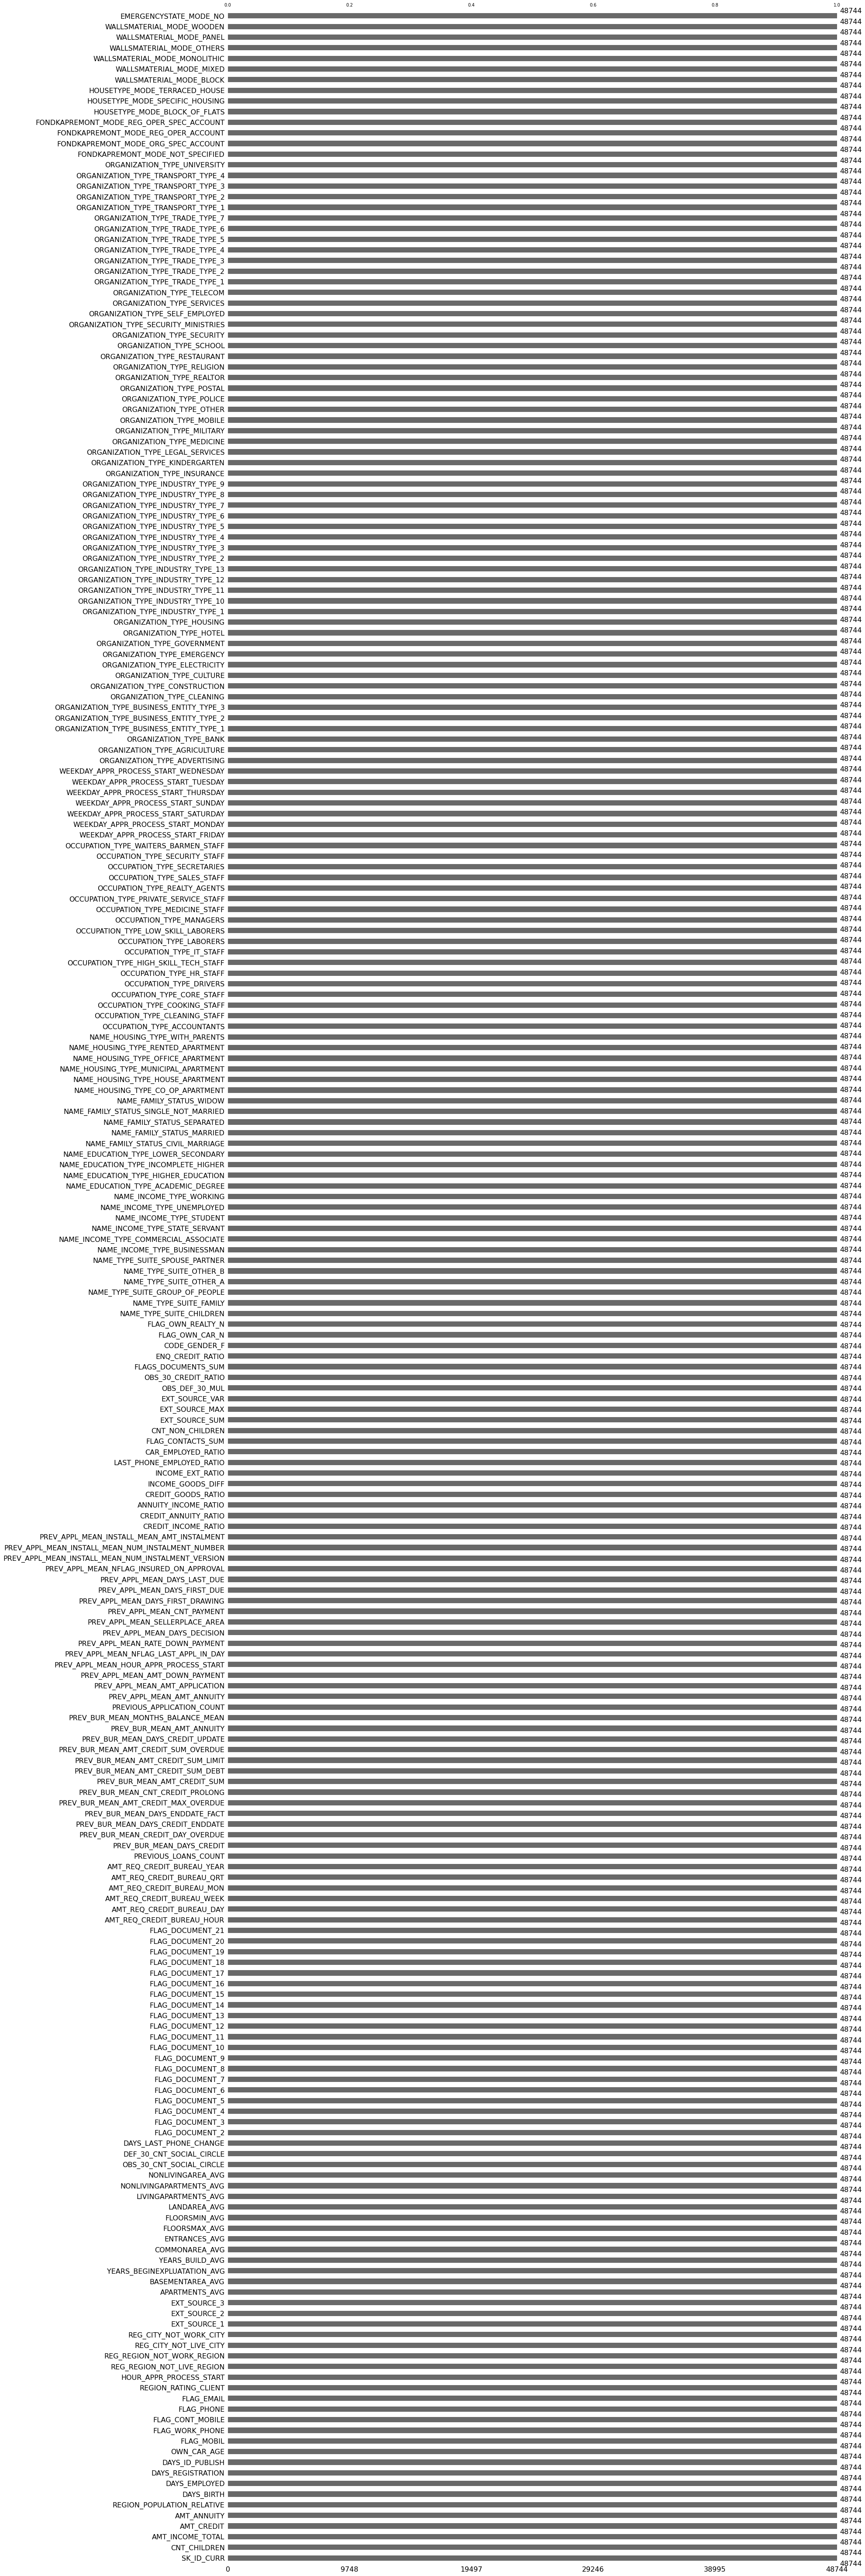

In [85]:
msno.bar(data_test)

<AxesSubplot:>

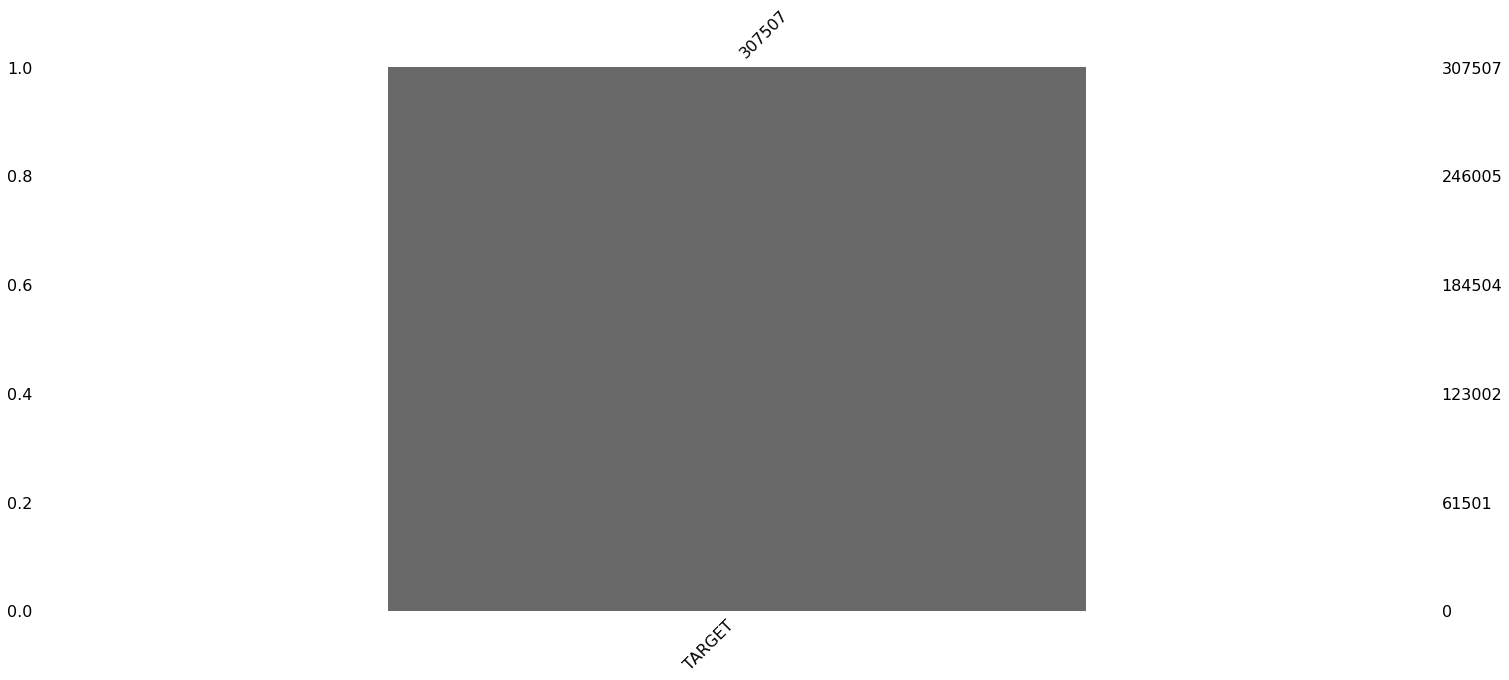

In [86]:
msno.bar(pd.DataFrame(target))

In [87]:
# enregistrement des données 

In [88]:
data_train.to_csv('data.csv')
data_test.to_csv('test_set.csv')
target.to_csv('target.csv')